# Baseline metrics

The `baseline` module contains several metrics that can help you to assess the quality of your segmentation.
This includes metrics to quantify the number of cells in your data, the number of transcripts/genes per cell, 
the percentage of unassigned transcripts, the transcript density, and a variety of morphological features

In [1]:
%load_ext autoreload
%autoreload 2

import math

import matplotlib.pyplot as plt
import spatialdata as sd

import segtraq as st

# this dataset was downloaded from https://spatialdata.scverse.org/en/latest/tutorials/notebooks/datasets/README.html#
# it is the third dataset in the list
sdata = sd.read_zarr("/g/huber/projects/CODEX/segtraq/data/spatialdata_xenium_breast_cancer_rep1.zarr")

/home/meyerben/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/meyerben/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.10/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/home/meyerben/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword 

Let's start by having a look at the `spatialdata` dataset.

In [2]:
sdata

SpatialData object, with associated Zarr store: /g/huber/projects/CODEX/segtraq/data/spatialdata_xenium_breast_cancer_rep1.zarr
├── Images
│     ├── 'morphology_focus': DataTree[cyx] (1, 25778, 35416), (1, 12889, 17708), (1, 6444, 8854), (1, 3222, 4427), (1, 1611, 2213)
│     └── 'morphology_mip': DataTree[cyx] (1, 25778, 35416), (1, 12889, 17708), (1, 6444, 8854), (1, 3222, 4427), (1, 1611, 2213)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 8) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (167780, 1) (2D shapes)
│     └── 'cell_circles': GeoDataFrame shape: (167780, 2) (2D shapes)
└── Tables
      └── 'table': AnnData (167780, 313)
with coordinate systems:
    ▸ 'global', with elements:
        morphology_focus (Images), morphology_mip (Images), transcripts (Points), cell_boundaries (Shapes), cell_circles (Shapes)

To get a first impression of the quality of the data, we can check how many cells there are in the data. We can also check how many transcripts were measured in total, how many genes they map to, and how many transcripts were not assigned to a cell.

In [3]:
st.bl.num_cells(sdata)

167780

In [4]:
st.bl.num_transcripts(sdata)

42638083

In [7]:
st.bl.num_genes(sdata)

541

In [8]:
st.bl.perc_unassigned_transcripts(sdata)

0.06603498098167312

Next, let's see how many transcripts were detected per cell. We can do this using the `transcripts_per_cell()` method.

In [9]:
transcripts_per_cell = st.bl.transcripts_per_cell(sdata)
# removing the background
transcripts_per_cell = transcripts_per_cell[transcripts_per_cell["cell_id"] != -1]
transcripts_per_cell.head()

,cell_id,transcript_count
1,82952,1703
2,11728,1652
3,1359,1592
4,105998,1568
5,79034,1519


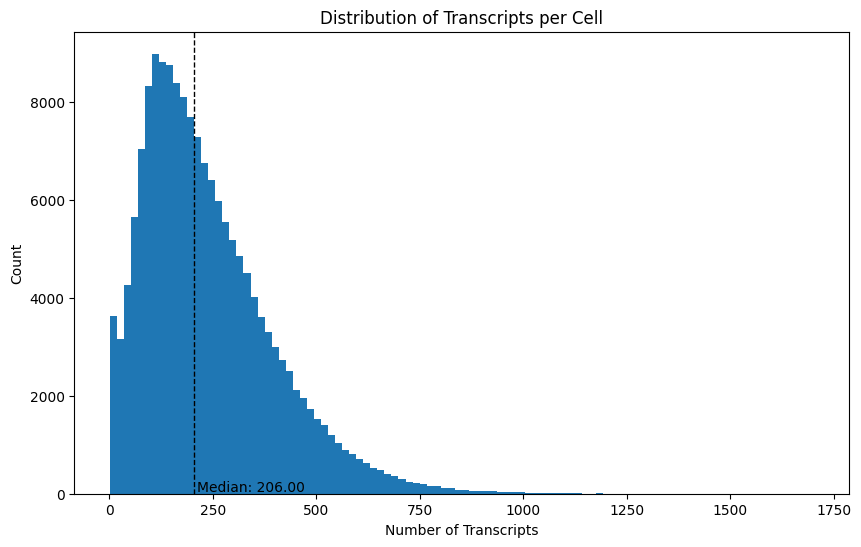

In [10]:
# plotting the number of transcripts per cell
plt.figure(figsize=(10, 6))
plt.hist(transcripts_per_cell["transcript_count"], bins=100)

# adding a line for the median
plt.axvline(
    transcripts_per_cell["transcript_count"].median(),
    color="black",
    linestyle="dashed",
    linewidth=1,
)
plt.text(
    transcripts_per_cell["transcript_count"].median() + 5,
    50,
    f"Median: {transcripts_per_cell['transcript_count'].median():.2f}",
    color="black",
)

# adding labels and title
plt.xlabel("Number of Transcripts")
plt.ylabel("Count")
plt.title("Distribution of Transcripts per Cell")
plt.show()

We can also do the same thing for the number of genes per cell, since there are often multiple transcripts measured per gene.

In [11]:
genes_per_cell = st.bl.genes_per_cell(sdata)
# removing the background
genes_per_cell = genes_per_cell[genes_per_cell["cell_id"] != -1]
genes_per_cell.head()

,cell_id,gene_count
1,1,21
2,2,40
3,3,10
4,4,9
5,5,35


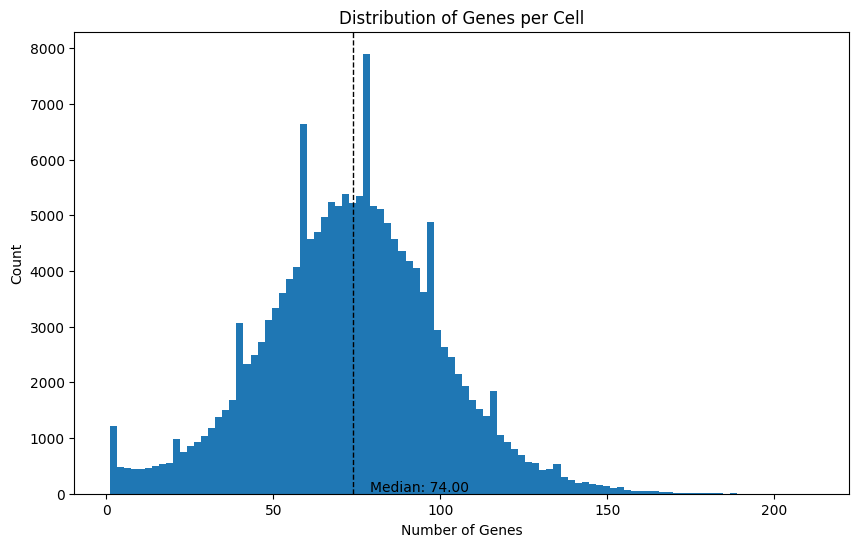

In [12]:
# plotting the number of genes per cell
plt.figure(figsize=(10, 6))
plt.hist(genes_per_cell["gene_count"], bins=100)

# adding a line for the median
plt.axvline(
    genes_per_cell["gene_count"].median(),
    color="black",
    linestyle="dashed",
    linewidth=1,
)
plt.text(
    genes_per_cell["gene_count"].median() + 5,
    50,
    f"Median: {genes_per_cell['gene_count'].median():.2f}",
    color="black",
)

# adding labels and title
plt.xlabel("Number of Genes")
plt.ylabel("Count")
plt.title("Distribution of Genes per Cell")
plt.show()

Next to the number of transcripts per cell, we can also investigate the transcript density, which is computed as the number of transcripts divided by the cell area. Note that the background does not appear in this data frame.

In [13]:
transcript_density = st.bl.transcript_density(sdata)
transcript_density.head()

,cell_id,transcript_density
1,82952,1.232467
2,11728,2.516099
3,1359,2.559001
4,105998,3.072366
5,79034,3.110092


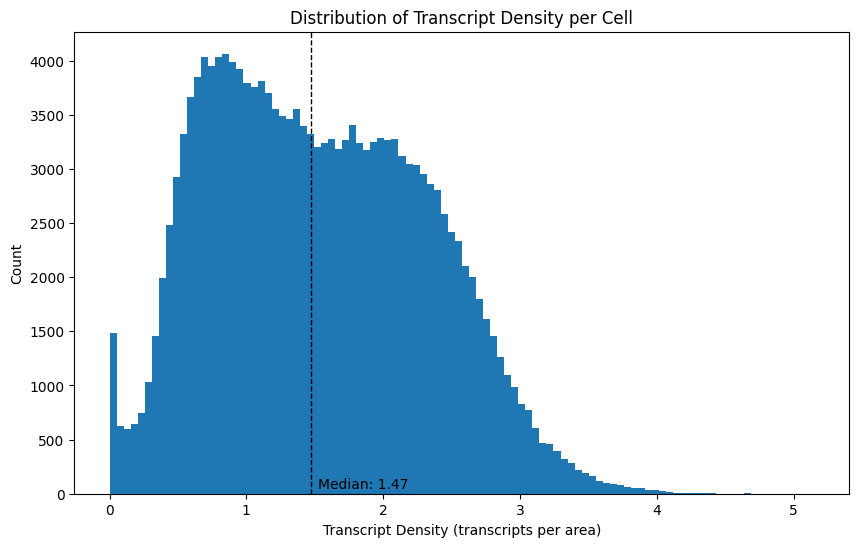

In [14]:
# plotting the transcript density per cell
plt.figure(figsize=(10, 6))
plt.hist(transcript_density["transcript_density"], bins=100)

# adding a line for the median
plt.axvline(
    transcript_density["transcript_density"].median(),
    color="black",
    linestyle="dashed",
    linewidth=1,
)
plt.text(
    transcript_density["transcript_density"].median() + 0.05,
    50,
    f"Median: {transcript_density['transcript_density'].median():.2f}",
    color="black",
)

# adding labels and title
plt.xlabel("Transcript Density (transcripts per area)")
plt.ylabel("Count")
plt.title("Distribution of Transcript Density per Cell")
plt.show()

Finally, let's look at some morphological features, such as the cell area, circularity, elongation, etc. We can get those with the function `morphological_features()`. If you only want to compute certain features, you can select them with the `features_to_compute` argument. This can drastically reduce the runtime, as especially the features `elongation` and `eccentricity` can take a while to compute.

In [15]:
morphological_features = st.bl.morphological_features(sdata)
morphological_features.head()

,cell_id,cell_area,perimeter,circularity,bbox_width,bbox_height,extent,solidity,convexity,elongation,eccentricity,compactness,sphericity
0,1,56.919458,30.298952,0.779140,10.625000,8.500000,0.630250,0.965899,0.983011,1.190205,0.542289,16.128517,0.779140
1,2,188.324123,59.574355,0.666802,20.400024,14.024994,0.658222,0.899008,0.955540,1.659024,0.797919,18.845720,0.666802
2,3,14.495154,17.303524,0.608364,6.375000,4.462494,0.509524,0.822026,0.970329,1.278102,0.622764,20.656002,0.608364
3,4,40.347058,24.257933,0.861617,8.287476,7.437500,0.654580,0.981329,0.999023,1.050888,0.307414,14.584639,0.861617
4,5,102.527238,40.730717,0.776614,10.412476,15.087494,0.652632,0.953189,0.989881,1.675849,0.802455,16.180981,0.776614


Let's plot all of the distributions in one plot using subplots.

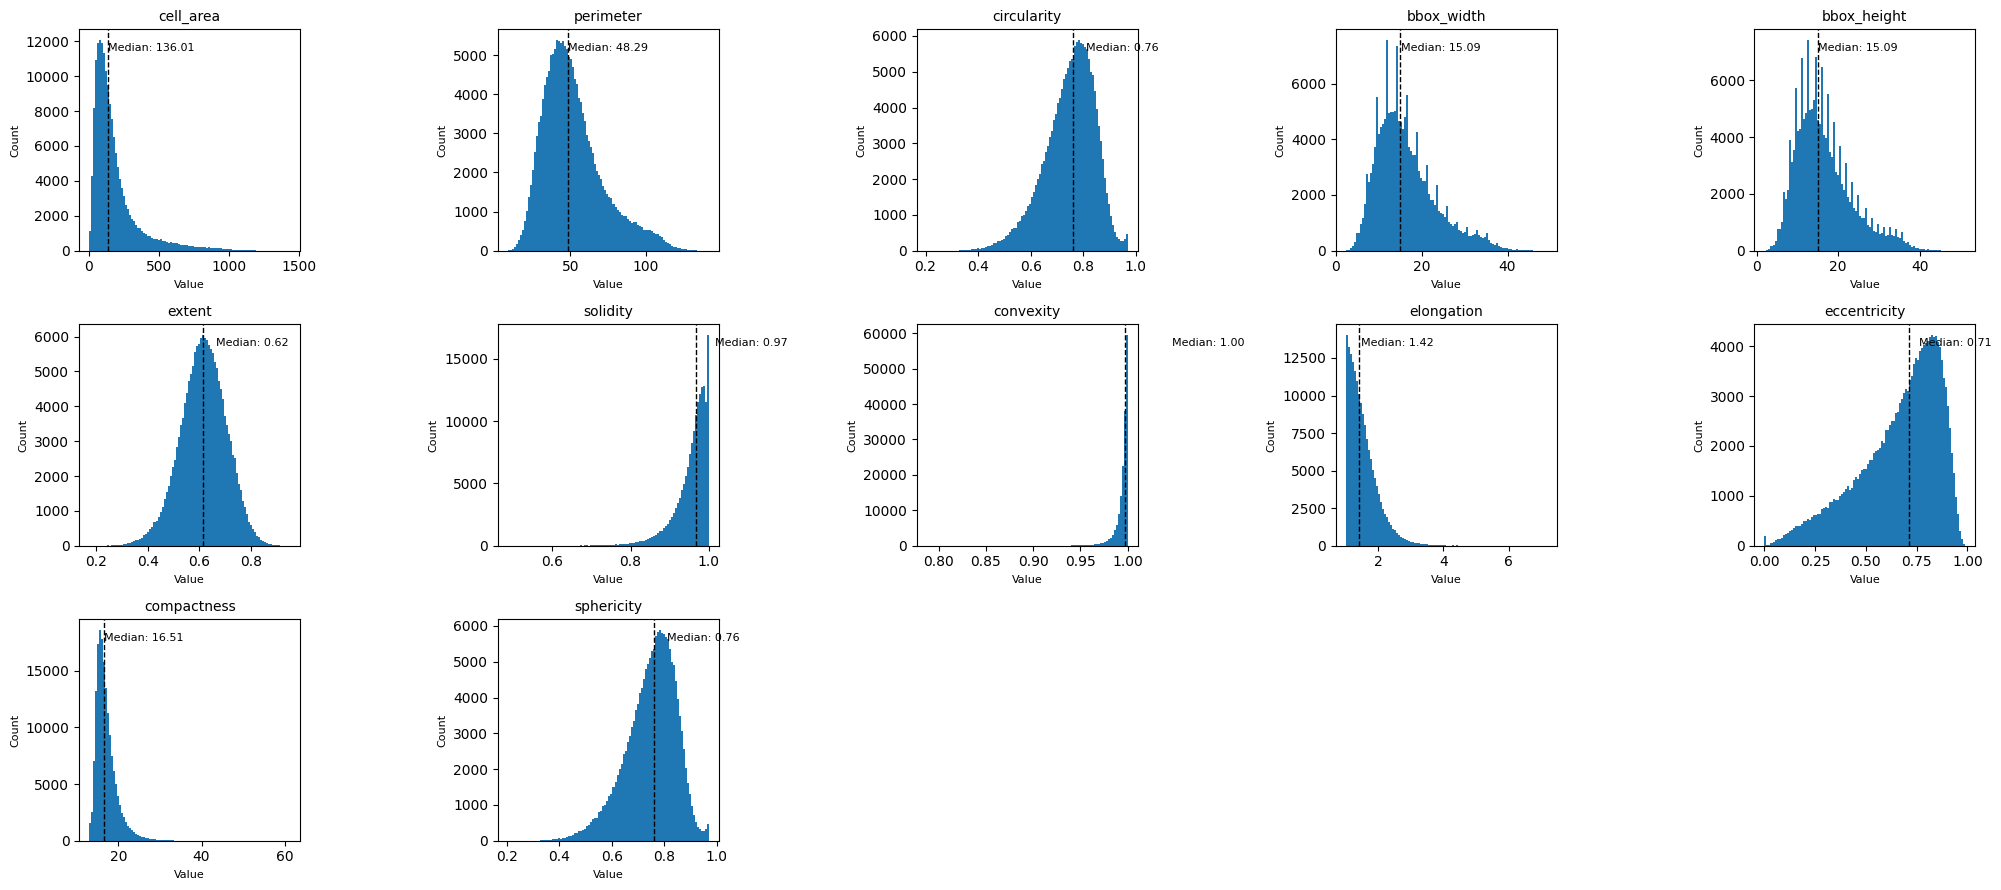

In [16]:
# exclude 'cell_id' from the features to plot
features = [f for f in morphological_features.columns if f != "cell_id"]

# define grid layout
num_features = len(features)
cols = 5
rows = math.ceil(num_features / cols)

# create subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]
    data = morphological_features[feature]

    ax.hist(data, bins=100)
    median_val = data.median()
    ax.axvline(median_val, color="black", linestyle="dashed", linewidth=1)
    ax.text(
        median_val + 0.05,
        ax.get_ylim()[1] * 0.9,
        f"Median: {median_val:.2f}",
        color="black",
        fontsize=8,
    )

    ax.set_title(feature, fontsize=10)
    ax.set_xlabel("Value", fontsize=8)
    ax.set_ylabel("Count", fontsize=8)

# hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()